In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import collections
import time
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score
import scipy as sp
from sklearn.manifold import MDS
from run_dist_mat import *
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

from mpl_toolkits.mplot3d import Axes3D
# from sklearn.neighbors import NearestNeighbors
# from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score, silhouette_samples 
pd.set_option('display.max_columns', None)

In [2]:
reads_to_include = "all" #"all"
clustering_method = "pckmeans" # "igs"
data = read_data(clustering_method, reads_to_include) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.

cell_id_to_id = {}
id_to_cell_id = {}
cids = np.array(data.cell_index.unique())
for i,cell_id in enumerate(cids):
    cell_id_to_id[cell_id] = i
    id_to_cell_id[i] = cell_id 
    
_4cell_cids = data.loc[data.stage == '4cell', 'cell_index'].unique()
# _4cell_ids = [cell_id_to_id[cid] for cid in _4cell_cids]
# _4cell_eids =  data.loc[data.stage == '4cell', 'embryo_id'].unique()
# _4cell_ids_embryo = np.array([i for i in _4cell_ids if data.loc[data.cell_index == id_to_cell_id[i], 'embryo_id'].unique() != data.loc[data.cell_index == id_to_cell_id[i-1], 'embryo_id'].unique()]) #ids at which we have a new embryo 
# _4cell_ids_embryo = np.append(_4cell_ids_embryo, cell_id_to_id[cell_indeces[-1]]+1 )
# _4cell_ids_embryo

ids = np.array([cell_id_to_id[cid] for cid in cids])
eids =  np.array(data.embryo_id.unique())
ids_embryo_change = np.array([i for i in ids[1:] if data.loc[data.cell_index == id_to_cell_id[i], 'embryo_id'].unique() != data.loc[data.cell_index == id_to_cell_id[i-1], 'embryo_id'].unique()]) #ids at which we have a new embryo 
ids_embryo_change = np.append(ids_embryo_change, cell_id_to_id[cids[-1]]+1 )



In [3]:
#building a dictionary that maps each chromosome number (int for autosomes, 'X' or 'Y' for allosomes) to the length
chrom_size_dict = {0:0}
with open("mm10.chrom.sizes") as f:
    for line in f:
        (k, v) = line.split()
        k = k[3:]
        try:
            k = int(k)
            chrom_size_dict[k] = int(v)
        except:
#             if k=='X' or k=='Y':
#                 chrom_size_dict[k] = int(v)
#             else:
            continue
chrom_size_dict = collections.OrderedDict(sorted(chrom_size_dict.items()))
lens = [val for key,val in chrom_size_dict.items()] #[0, len_chr1, len_chr2,...]
cum_lens = np.cumsum(lens) #[0,len_chr1, len_chr1 + len_chr2,...]

In [4]:
for bin_size in [200e6, 100e6, 50e6, 25e6, 10e6, 5e6]:
    BINS = []
    # bin_size = 20000000
    cum_len_extended = np.append(cum_lens.copy(), cum_lens[-1]+bin_size)
    for ch in range(0,20):
        BINS.extend(np.arange(cum_len_extended[ch],cum_len_extended[ch+1], bin_size))
    print("bin_size: {} Mbp, number of bins: {}".format(int(bin_size/1e6), len(BINS)-1))
    NUM_BINS = len(BINS)- 1

bin_size: 200 Mbp, number of bins: 19
bin_size: 100 Mbp, number of bins: 34
bin_size: 50 Mbp, number of bins: 58
bin_size: 25 Mbp, number of bins: 106
bin_size: 10 Mbp, number of bins: 258
bin_size: 5 Mbp, number of bins: 503


number of bins:  19


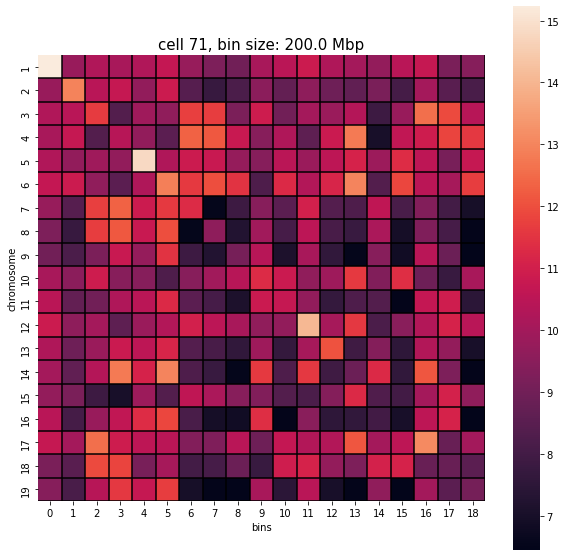

number of bins:  34


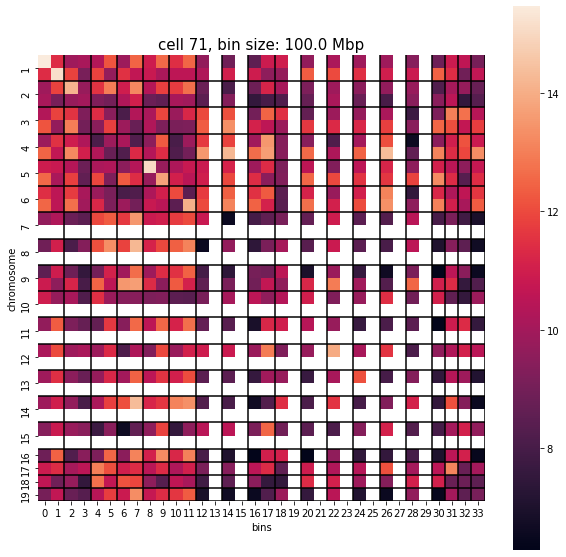

number of bins:  58


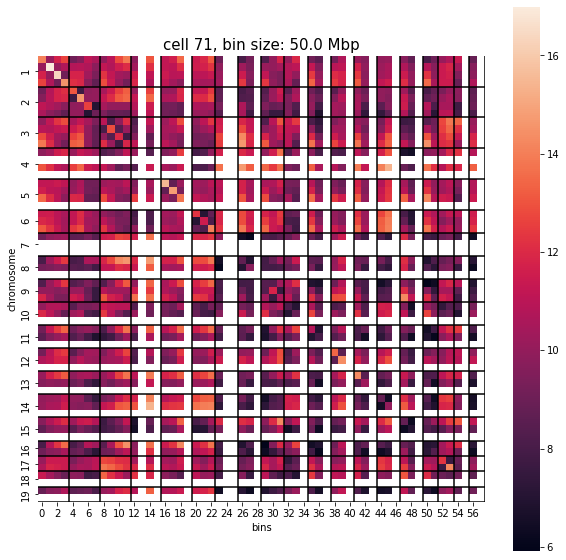

number of bins:  106


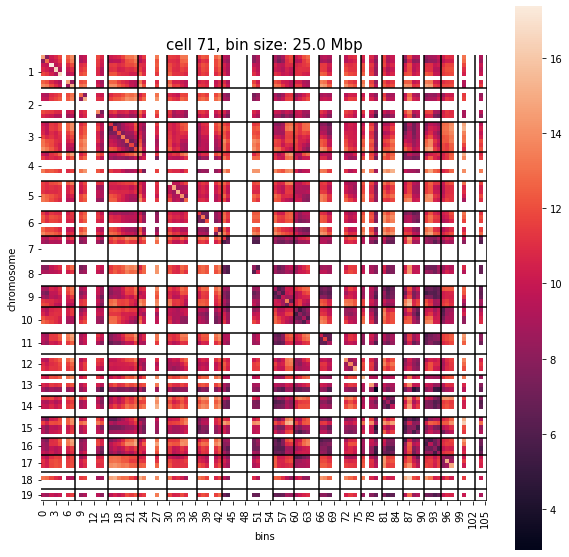

number of bins:  258


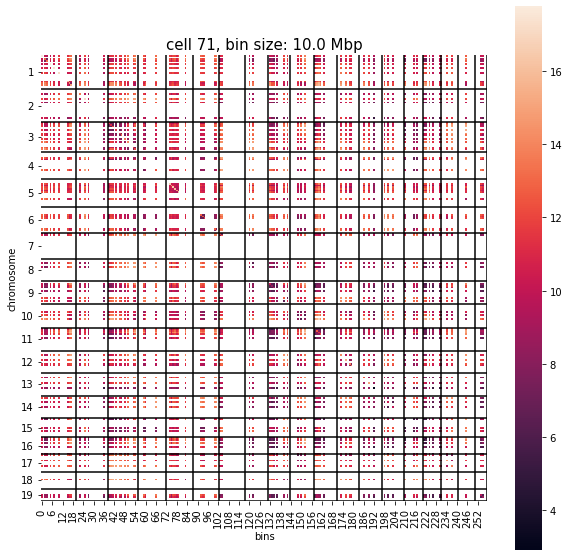

number of bins:  503


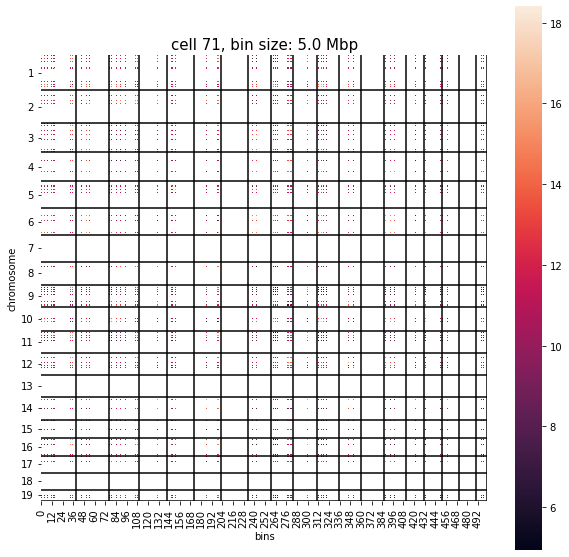

In [5]:
cell_index = 71

cell = data.loc[(data.cell_index==cell_index) & (data.chr < 20)].copy()
cell['abs_pos'] = -1
cell['abs_pos'] = cell.pos.copy() + [cum_lens[ch-1] for ch in cell.chr] #encodes the absolute position of the reads along the linear genome
   

for bin_size in [200e6, 100e6, 50e6, 25e6, 10e6, 5e6]:
    bins = []
    cum_len_extended = np.append(cum_lens.copy(), cum_lens[-1]+bin_size)
    for ch in range(0,20):
        bins.extend(np.arange(cum_len_extended[ch],cum_len_extended[ch+1], bin_size))
    print("number of bins: ",len(bins)-1)
    NUM_BINS = len(bins)- 1


    cell_dist_mat = pckmeans_get_chr_average_dist_mat_binned(cell, bins)



    chr_inds = []
    bin_centers = []
    for i in range(1,20):
        bin_start = np.where(bins==cum_lens[i-1])[0][0]
        bin_end = np.where(bins==cum_lens[i])[0][0]
        chr_inds.append(bin_end)
        bin_centers.append((bin_start + bin_end)/2)


    plt.figure(figsize = (10,10))
    ax = sns.heatmap(cell_dist_mat, square = True)
    ax.vlines(chr_inds, *ax.get_xlim(), color = 'black')
    ax.hlines(chr_inds, *ax.get_xlim(), color = 'black')
    ax.set_yticks(bin_centers)
    ax.set_yticklabels(np.arange(1,20))
    ax.set_xlabel("bins")
    ax.set_ylabel("chromosome")
    ax.set_title("cell {}, bin size: {} Mbp".format(cell_index, bin_size/1e6), fontsize = 15 )
    plt.show()


Text(0.5, 1.0, 'inter-cell num_bins in common')

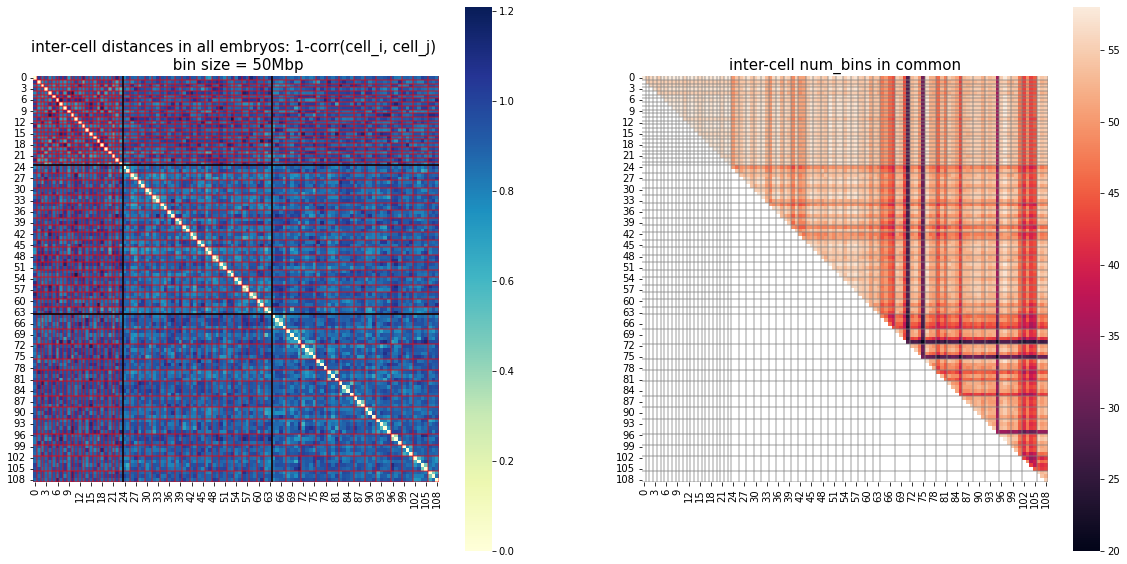

In [6]:
bin_size = 50 #Mbp


method = "chr_average_binned"
inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2




intersection = np.load("data/inter_cell_intersection_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))

fig, axes = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(dist, ax = axes[0], square = True, cmap = 'YlGnBu')
axes[0].vlines(ids_embryo_change,color = 'red', *axes[0].get_xlim(), alpha = 0.5) #drawing vertical lines separating the stages
axes[0].hlines(ids_embryo_change,color = 'red', *axes[0].get_xlim(), alpha = 0.5)
axes[0].vlines([24,64],color = 'black', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].hlines([24,64],color = 'black', *axes[0].get_xlim())
axes[0].set_title("inter-cell distances in all embryos: 1-corr(cell_i, cell_j) \n bin size = {}Mbp".format(bin_size), fontsize = 15)

sns.heatmap(intersection, ax = axes[1], square = True )
axes[1].vlines(ids_embryo_change,color = 'gray', *axes[0].get_xlim(), alpha = 0.5) #drawing vertical lines separating the stages
axes[1].hlines(ids_embryo_change,color = 'gray', *axes[0].get_xlim(), alpha = 0.5)
axes[1].set_title("inter-cell num_bins in common", fontsize = 15)


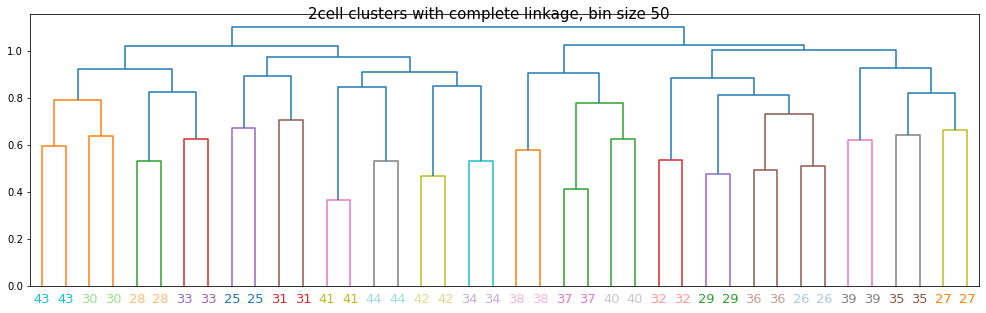

In [7]:
#Hierarchical Clustering on the 2cell Embryos
linkage_type = 'complete'

embryo_labels_2cell = [data.loc[data.cell_index==cid,'embryo_id'].unique()[0] for cid in cids[24:64]]

dist_2cell = dist[24:64,24:64]
idx = np.triu_indices(dist_2cell.shape[0], k = 1)
dist_2cell_unrav = dist_2cell[idx]

X = dist_2cell_unrav
linked = linkage(X, linkage_type)

fig, axes = plt.subplots(1,1, figsize = (17,5))
dendrogram(linked,
            orientation='top',
            labels= embryo_labels_2cell,
           color_threshold = 0.8,
            distance_sort='ascending',
           leaf_font_size = 13,
           leaf_rotation = 0,
            show_leaf_counts=True, 
          ax = axes)

#changing the color of the nodes
embryos = np.sort(np.unique(embryo_labels_2cell))
vals = np.arange(0,len(embryos))
embryo_color_dict = dict(zip(embryos, vals))
color_list = plt.cm.tab20(vals)
xlbls = axes.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_list[embryo_color_dict[int(lbl.get_text()[0:2])]])
    
plt.suptitle("2cell clusters with {} linkage, bin size {}".format(linkage_type,bin_size), y = 0.9, fontsize = 15)
plt.savefig("figures/hierarchical_clusters_2cell_{}_{}_bin_size_{}.png".format(clustering_method, reads_to_include, bin_size))
plt.show()


Text(0.5, 1.0, 'inter-cell distance in 4cell embryos: 1-corr(cell_i, cell_j)')

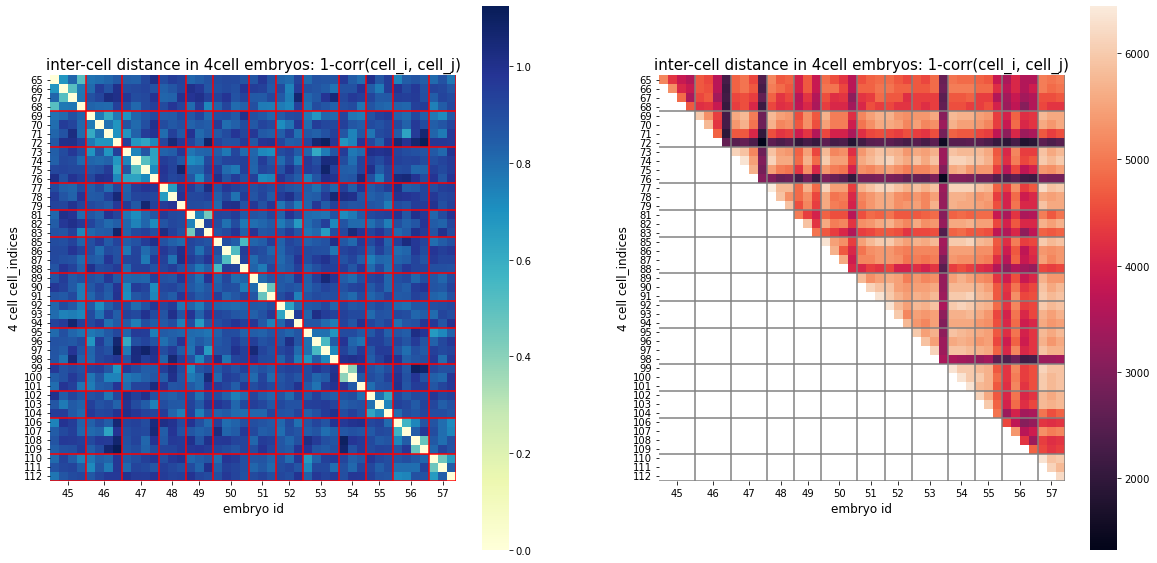

In [8]:
dist_4cell = dist[64:,64:]
intersection_4cell = intersection[64:,64:]



intersection_4cell = np.load("data/inter_cell_aligned_dist_intersection_size_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))

fig, axes = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(dist_4cell, ax = axes[0], square = True, cmap = 'YlGnBu')
axes[0].vlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].hlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2 - 64)
axes[0].set_xticklabels(eids[-13:])
axes[0].set_yticklabels(cids[64:])
axes[0].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[0].set_xlabel("embryo id", fontsize = 12)
axes[0].set_title("inter-cell distance in 4cell embryos: 1-corr(cell_i, cell_j)", fontsize = 15)

sns.heatmap(intersection_4cell, ax = axes[1], square = True )
axes[1].vlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].hlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2 - 64)
axes[1].set_xticklabels(eids[-13:])
axes[1].set_yticklabels(cids[64:])
axes[1].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[1].set_xlabel("embryo id", fontsize = 12)
axes[1].set_title("inter-cell distance in 4cell embryos: 1-corr(cell_i, cell_j)", fontsize = 15)


In [9]:
#Here, we construct an ordered list of ids based on within-embro similarities
# within each embryo, i take the cells with the highest correlation (lowest distance) and put them next to each other
ordered_ids_4cell = []
for eid in eids[-13:]:
    cids_in_embryo =  data.loc[data.embryo_id == eid, 'cell_index'].unique()
    ids_in_embryo = [cell_id_to_id[cid] for cid in cids_in_embryo]
    embryo_dist = np.triu(dist[np.ix_(ids_in_embryo,ids_in_embryo)], k = 1) #we don't include the diagonal
    embryo_dist[embryo_dist==0] = 10 #so we don't pick the zero values as min
    max_id_i, max_id_j = np.unravel_index(embryo_dist.argmin(), embryo_dist.shape)
    max_cid_i, max_cid_j = cids_in_embryo[max_id_i], cids_in_embryo[max_id_j]
    other_cids = [cid for cid in cids_in_embryo if cid not in [max_cid_i, max_cid_j]]

    ordered_ids_4cell.append(cell_id_to_id[max_cid_i])
    ordered_ids_4cell.append(cell_id_to_id[max_cid_j])
    for other_cid in other_cids:
        ordered_ids_4cell.append(cell_id_to_id[other_cid])
    

Text(0.5, 1.0, 'inter-cell num_bins in common')

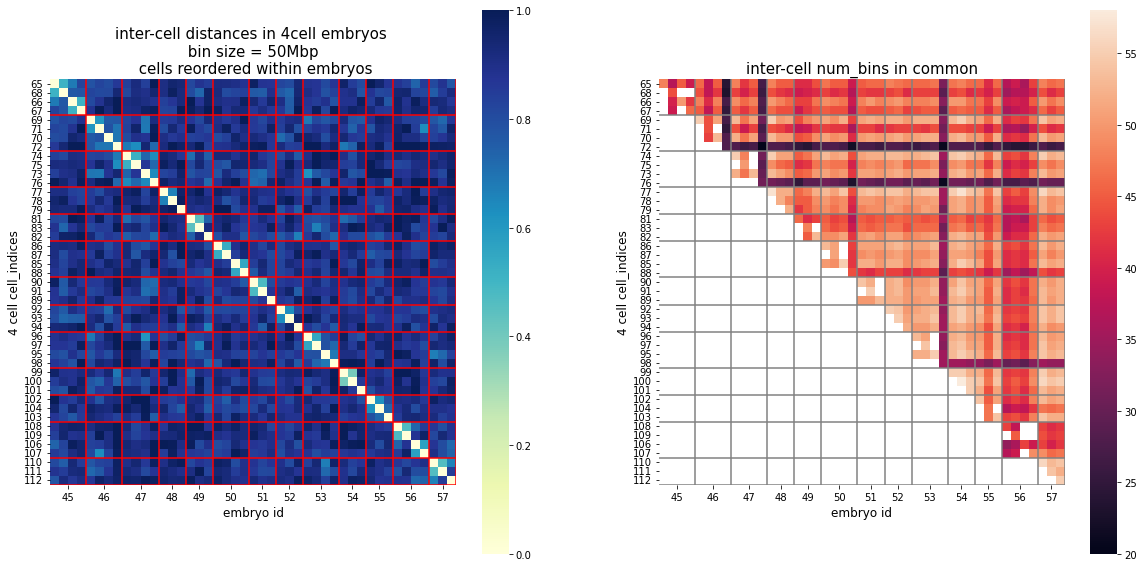

In [10]:
fig, axes = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(dist[np.ix_(ordered_ids_4cell,ordered_ids_4cell)], ax = axes[0], vmax = 1, square = True, cmap = 'YlGnBu')
axes[0].vlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].hlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2 - 64)
axes[0].set_xticklabels(eids[-13:])
axes[0].set_yticklabels([id_to_cell_id[i] for i in ordered_ids_4cell])
axes[0].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[0].set_xlabel("embryo id", fontsize = 12)
axes[0].set_title("inter-cell distances in 4cell embryos \n bin size = {}Mbp \n cells reordered within embryos".format(bin_size), fontsize = 15)

sns.heatmap(intersection[np.ix_(ordered_ids_4cell,ordered_ids_4cell)], ax = axes[1], square = True )
axes[1].vlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].hlines(ids_embryo_change[ids_embryo_change>64]-64,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2 - 64)
axes[1].set_xticklabels(eids[-13:])
axes[1].set_yticklabels([id_to_cell_id[i] for i in ordered_ids_4cell])
axes[1].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[1].set_xlabel("embryo id", fontsize = 12)
axes[1].set_title("inter-cell num_bins in common", fontsize = 15)


In [12]:
div = {45: 'p',
      46: 't',
      47: 't',
      48: '?',
      49: '?',
      50: 't',
      51: '?',
      52: '?',
      53: 'p',
      54: '?',
      55: 't',
      56: 'p',
      57: '?'}

cids_4cells = cids[-45:]
embryo_labels = []
for i,cid in enumerate(cids_4cells):
    embryo_labels.append(data.loc[data.cell_index ==cid, 'embryo_id'].unique()[0]) 
embryo_labels = np.array(embryo_labels)

embryo_labels_annot = [str(lab) + "\n" + div[lab] for lab in embryo_labels]

In [1]:
# plt.figure(figsize = )
%matplotlib inline
fig, axes = plt.subplots(1,13, figsize = (15,1))
for counter, eid in enumerate(eids[-13:]):
    embryo_cids = data.loc[data.embryo_id == eid, 'cell_index'].unique()
    ordered_ids_embryo = [i for i in ordered_ids_4cell if id_to_cell_id[i] in embryo_cids]
    sns.heatmap(dist[np.ix_(ordered_ids_embryo,ordered_ids_embryo)], ax = axes[counter], \
                cbar = False,cmap = 'YlGnBu', vmin = 0, vmax = 1.2, yticklabels=False)
    axes[counter].set_title(str(eid) + ": " + div[eid])
    axes[counter].set_xticklabels([id_to_cell_id[i] for i in ordered_ids_embryo], rotation = 45)

plt.suptitle("within embryo distances   bin size = {}".format(bin_size), y = -0.3)
plt.show()
# plt.tight_layout()
    

NameError: name 'plt' is not defined

In [14]:
with open('genome_mixing_metrics_dict.pkl', 'rb') as f:
    genome_mixing_metrics = pickle.load(f)
num_snps = np.load("genome_mixing_num_snps.npy")
method_names = ["Sum_of_Squares", "Silhouette", "Linear Classifier", "nearest neighbors", 'Bhattacharyya_dist']
method = "Bhattacharyya_dist"


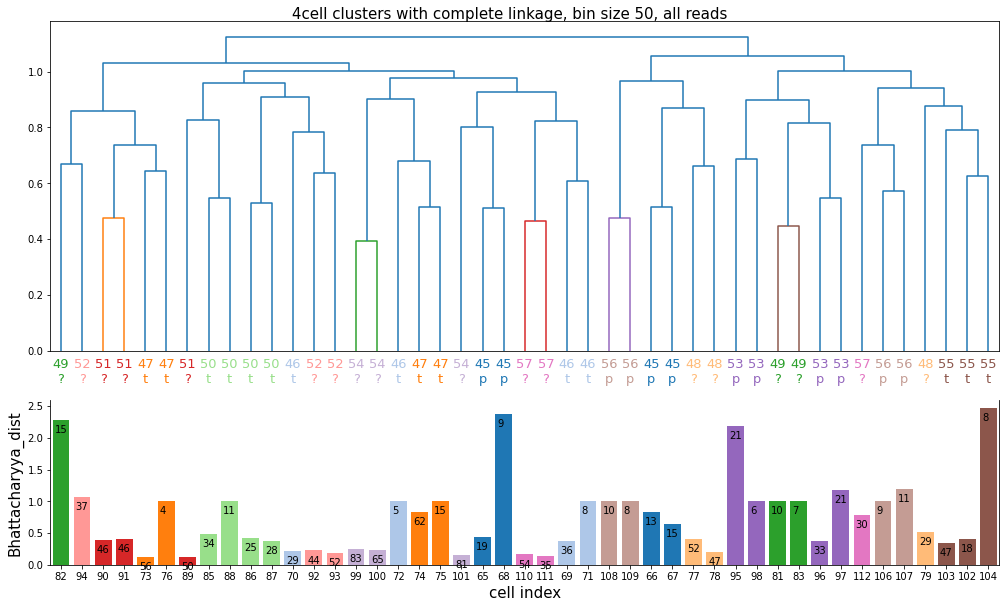

In [16]:
linkage_type = 'complete'


dist_4cell = dist[-45:,-45:]
idx = np.triu_indices(45, k = 1)
dist_4cell_unrav = dist_4cell[idx]

X = dist_4cell_unrav
linked = linkage(X, linkage_type)

fig, axes = plt.subplots(2,1, figsize = (17,10),gridspec_kw={'height_ratios': [2,1]})
dendrogram(linked,
            orientation='top',
            labels= embryo_labels_annot,
           color_threshold = 0.5,
            distance_sort='ascending',
           leaf_font_size = 13,
           leaf_rotation = 0,
            show_leaf_counts=True, 
          ax = axes[0])

#changing the color of the nodes
embryos = np.sort(eids[-13:])
vals = np.arange(0,len(embryos))
embryo_color_dict = dict(zip(embryos, vals))
color_list = plt.cm.tab20(vals)
xlbls = axes[0].get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_list[embryo_color_dict[int(lbl.get_text()[0:2])]])
    
    
axes[1].bar(np.arange(0,45), np.array(genome_mixing_metrics[method])[leaves_list(linked)], 
            color = color_list[[embryo_color_dict[i] for i in embryo_labels[leaves_list(linked)]]])
for i in range(45):
    axes[1].text(i-0.3, np.array(genome_mixing_metrics[method])[leaves_list(linked)[i]] - 0.2,s= num_snps[leaves_list(linked)[i]] )
axes[1].set_xlim(-0.5,44.5)
axes[1].set_xticks(np.arange(0,45))
axes[1].set_xticklabels([str(lab) for lab in _4cell_cids[leaves_list(linked)]])
axes[1].spines['top'].set_visible(False)
axes[1].set_xlabel("cell index", fontsize = 15)
axes[1].set_ylabel(method, fontsize = 15)

plt.suptitle("4cell clusters with {} linkage, bin size {}, {} reads".format(linkage_type,bin_size, reads_to_include), y = 0.9, fontsize = 15)
plt.savefig("figures/hierarchical_clusters_4cell_{}_{}_bin_size_{}.png".format(clustering_method, reads_to_include, bin_size))
plt.show()


In [ ]:
https://stackoverflow.com/questions/38153829/custom-cluster-colors-of-scipy-dendrogram-in-python-link-color-func

Text(0.5, 0.92, 'bin size: 25.0')

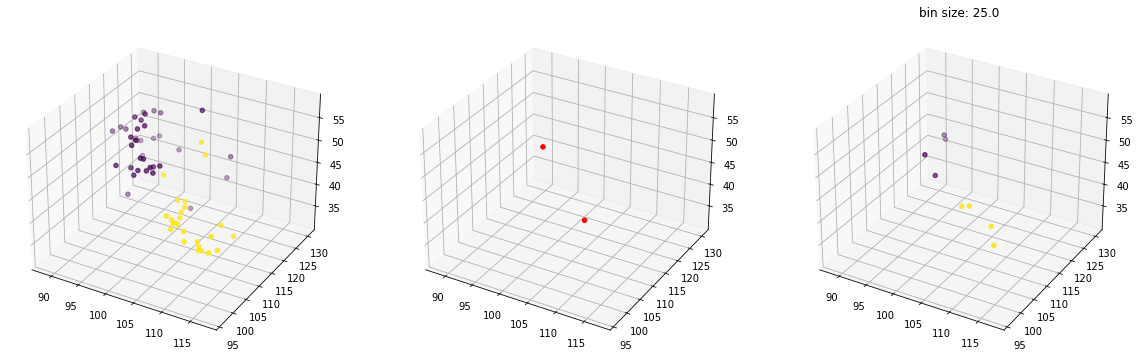

In [49]:
cell_id = 3
ch = 18
bin_size = 25e6

chr_ = data.loc[(data.chr==ch)&(data.cell_index == cell_id)]
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(chr_.x_um_abs, chr_.y_um_abs, chr_.z_um_abs, c = chr_.pckmeans_cluster)


ax = fig.add_subplot(132, projection='3d')
ax.scatter(chr_.groupby('pckmeans_cluster').x_um_abs.mean(), chr_.groupby('pckmeans_cluster').y_um_abs.mean(), chr_.groupby('pckmeans_cluster').z_um_abs.mean(), alpha = 1,c = 'red')
ax.set_xlim(*ax1.get_xlim())
ax.set_ylim(*ax1.get_ylim())
ax.set_zlim(*ax1.get_zlim())

bins = np.arange(0,lens[ch]+bin_size, bin_size)
# groups = chr_.groupby([pd.cut(chr_.pos, bins),pd.cut(chr_.pckmeans_cluster, [-0.1,0.9,2])], dropna = True)
groups = chr_.groupby([pd.cut(chr_.pos, bins),pd.cut(chr_.pckmeans_cluster, [-0.1,0.9,2])]).mean().reindex(pd.MultiIndex.from_product([bins[1:], [0,1]]), fill_value = np.nan)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(groups.x_um_abs, groups.y_um_abs, groups.z_um_abs, c = groups.pckmeans_cluster)
ax.set_xlim(*ax1.get_xlim())
ax.set_ylim(*ax1.get_ylim())
ax.set_zlim(*ax1.get_zlim())
ax.set_title("bin size: {}".format(bin_size/1e6))


In [85]:
cell = data.loc[(data.cell_index==99) & (data.chr < 20)]
cell['abs_pos'] = -1
cell['abs_pos'] = cell.pos.copy() + [cum_lens[ch-1] for ch in cell.chr] 
    
pckmeans_get_dist_mat_binned(cell, bins)

# .reset_index(drop=True)##


/tmp/ipykernel_10690/1242621898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell['abs_pos'] = -1
/tmp/ipykernel_10690/1242621898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell['abs_pos'] = cell.pos.copy() + [cum_lens[ch-1] for ch in cell.chr]


array([[ 0.        ,  8.60684296,  3.44838603,  8.96105679,  1.84770444,
        10.61631122,  4.4746436 , 11.6199892 ],
       [ 8.60684296,  0.        ,  5.17338799,  2.9736792 ,  7.54309516,
         2.66541337,  4.1991411 ,  4.30270587],
       [ 3.44838603,  5.17338799,  0.        ,  5.94072597,  2.77220092,
         7.29614213,  1.12449485,  8.45375312],
       [ 8.96105679,  2.9736792 ,  5.94072597,  0.        ,  7.42474594,
         2.58558417,  4.95762003,  3.29395513],
       [ 1.84770444,  7.54309516,  2.77220092,  7.42474594,  0.        ,
         9.30546261,  3.54418285, 10.19643644],
       [10.61631122,  2.66541337,  7.29614213,  2.58558417,  9.30546261,
         0.        ,  6.21104065,  1.71753483],
       [ 4.4746436 ,  4.1991411 ,  1.12449485,  4.95762003,  3.54418285,
         6.21104065,  0.        ,  7.34543569],
       [11.6199892 ,  4.30270587,  8.45375312,  3.29395513, 10.19643644,
         1.71753483,  7.34543569,  0.        ]])

## Resampling

In [33]:
cell_index = 71

cell = data.loc[(data.cell_index==cell_index) & (data.chr < 20)].copy()
cell['abs_pos'] = -1
cell['abs_pos'] = cell.pos.copy() + [cum_lens[ch-1] for ch in cell.chr] #encodes the absolute position of the reads along the linear genome
   

bin_size = 100e6
bins = []
cum_len_extended = np.append(cum_lens.copy(), cum_lens[-1]+bin_size)
for ch in range(0,20):
    bins.extend(np.arange(cum_len_extended[ch],cum_len_extended[ch+1], bin_size))
print("number of bins: ",len(bins)-1)
NUM_BINS = len(bins)- 1



pckmeans_get_dist_mat_binned_resample(cell, bins)

number of bins:  34


embryo_id  cell_id  cell_index      amp_ind   x_um_abs  \
1.000000e+08 0       46.0      3.0        71.0  1306.000000  79.869950   
             1       46.0      3.0        71.0  1437.000000  89.231896   
1.954720e+08 0       46.0      3.0        71.0  1072.500000  75.762249   
             1       46.0      3.0        71.0  1070.111111  87.263811   
2.954720e+08 0       46.0      3.0        71.0  1190.000000  83.797092   
...                   ...      ...         ...          ...        ...   
2.310611e+09 1       46.0      3.0        71.0  1016.909091  87.707000   
2.401314e+09 0       46.0      3.0        71.0   563.000000  86.884639   
             1       46.0      3.0        71.0   934.666667  78.922019   
2.462745e+09 0       46.0      3.0        71.0  1208.000000  84.808219   
             1       46.0      3.0        71.0   987.833333  89.593013   

                  y_um_abs   z_um_abs   chr           pos  rel_chr_pos  \
1.000000e+08 0  146.360532  61.450000   1.0  4.563008e+07     0.233435   
             1  158.584327  59.966667   1.0  4.421723e+07     0.226208   
1.954720e+08 0  149.755028  57.033333   1.0  1.342036e+08     0.686562   
             1  159.282486  54.466667   1.0  1.531051e+08     0.783259   
2.954720e+08 0  161.094087  59.800000   2.0  5.322547e+07     0.292266   
...                    ...        ...   ...           ...          ...   
2.310611e+09 1  156.617883  64.636364  17.0  4.392972e+07     0.462480   
2.401314e+09 0  155.839841  57.200000  18.0  2.555553e+07     0.281751   
             1  159.342672  55.800000  18.0  5.197226e+07     0.572996   
2.462745e+09 0  152.120341  62.866667  19.0  3.417292e+07     0.556276   
             1  154.323152  55.466667  19.0  2.720199e+07     0.442802   

                  frag_len  hap1_reads  hap2_reads  \
1.000000e+08 0  193.375000         0.0    0.000000   
             1  296.000000         0.0    0.000000   
1.954720e+08 0  165.416667         0.0    0.000000   
             1  315.777778         0.0    0.000000   
2.954720e+08 0  197.750000         0.0    0.000000   
...                    ...         ...         ...   
2.310611e+09 1  223.300000         0.0    0.000000   
2.401314e+09 0  144.000000         0.0    0.000000   
             1  350.500000         0.0    0.000000   
2.462745e+09 0  282.000000         0.0    0.000000   
             1  242.333333         0.0    0.666667   

                pckmeans_before_correction  pckmeans_cluster   outlier  \
1.000000e+08 0                         0.0               0.0  0.000000   
             1                         1.0               1.0  0.083333   
1.954720e+08 0                         0.0               0.0  0.000000   
             1                         1.0               1.0  0.222222   
2.954720e+08 0                         0.0               0.0  0.000000   
...                                    ...               ...       ...   
2.310611e+09 1                         1.0               1.0  0.000000   
2.401314e+09 0                         0.0               0.0  0.000000   
             1                         1.0               1.0  0.000000   
2.462745e+09 0                         0.0               0.0  0.000000   
             1                         1.0               1.0  0.000000   

                pckmeans_cluster_hap       abs_pos  
1.000000e+08 0                  -1.0  4.563008e+07  
             1                  -1.0  4.421723e+07  
1.954720e+08 0                  -1.0  1.342036e+08  
             1                  -1.0  1.531051e+08  
2.954720e+08 0                  -1.0  2.486974e+08  
...                              ...           ...  
2.310611e+09 1                   0.0  2.259554e+09  
2.401314e+09 0                  -1.0  2.336167e+09  
             1                  -1.0  2.362583e+09  
2.462745e+09 0                   0.0  2.435487e+09  
             1                   1.0  2.428516e+09  

[68 rows x 18 columns]

# MDS on 4cells

In [41]:
def get_dist( xi, xj):
    return np.linalg.norm(xi - xj)

def stress(D, embedding):
    stress = 0
    n = embedding.shape[0]
    normalization = 0
    for i in range(n):
        for j in range(i+1, n):
            stress += (get_dist(embedding[i],embedding[j]) - D[i,j])**2
            normalization += D[i,j]**2
    return np.round(np.sqrt(stress/normalization), 3)


silhouette before MDS:  0.3518763097024566
silhouette before MDS:  0.2525192035218863
silhouette before MDS:  0.27178887823507675
silhouette before MDS:  0.25700370755249397
silhouette before MDS:  0.35108919621610746
silhouette before MDS:  0.22569848154088618
silhouette before MDS:  0.24927350335943194
silhouette before MDS:  0.2345459430172329


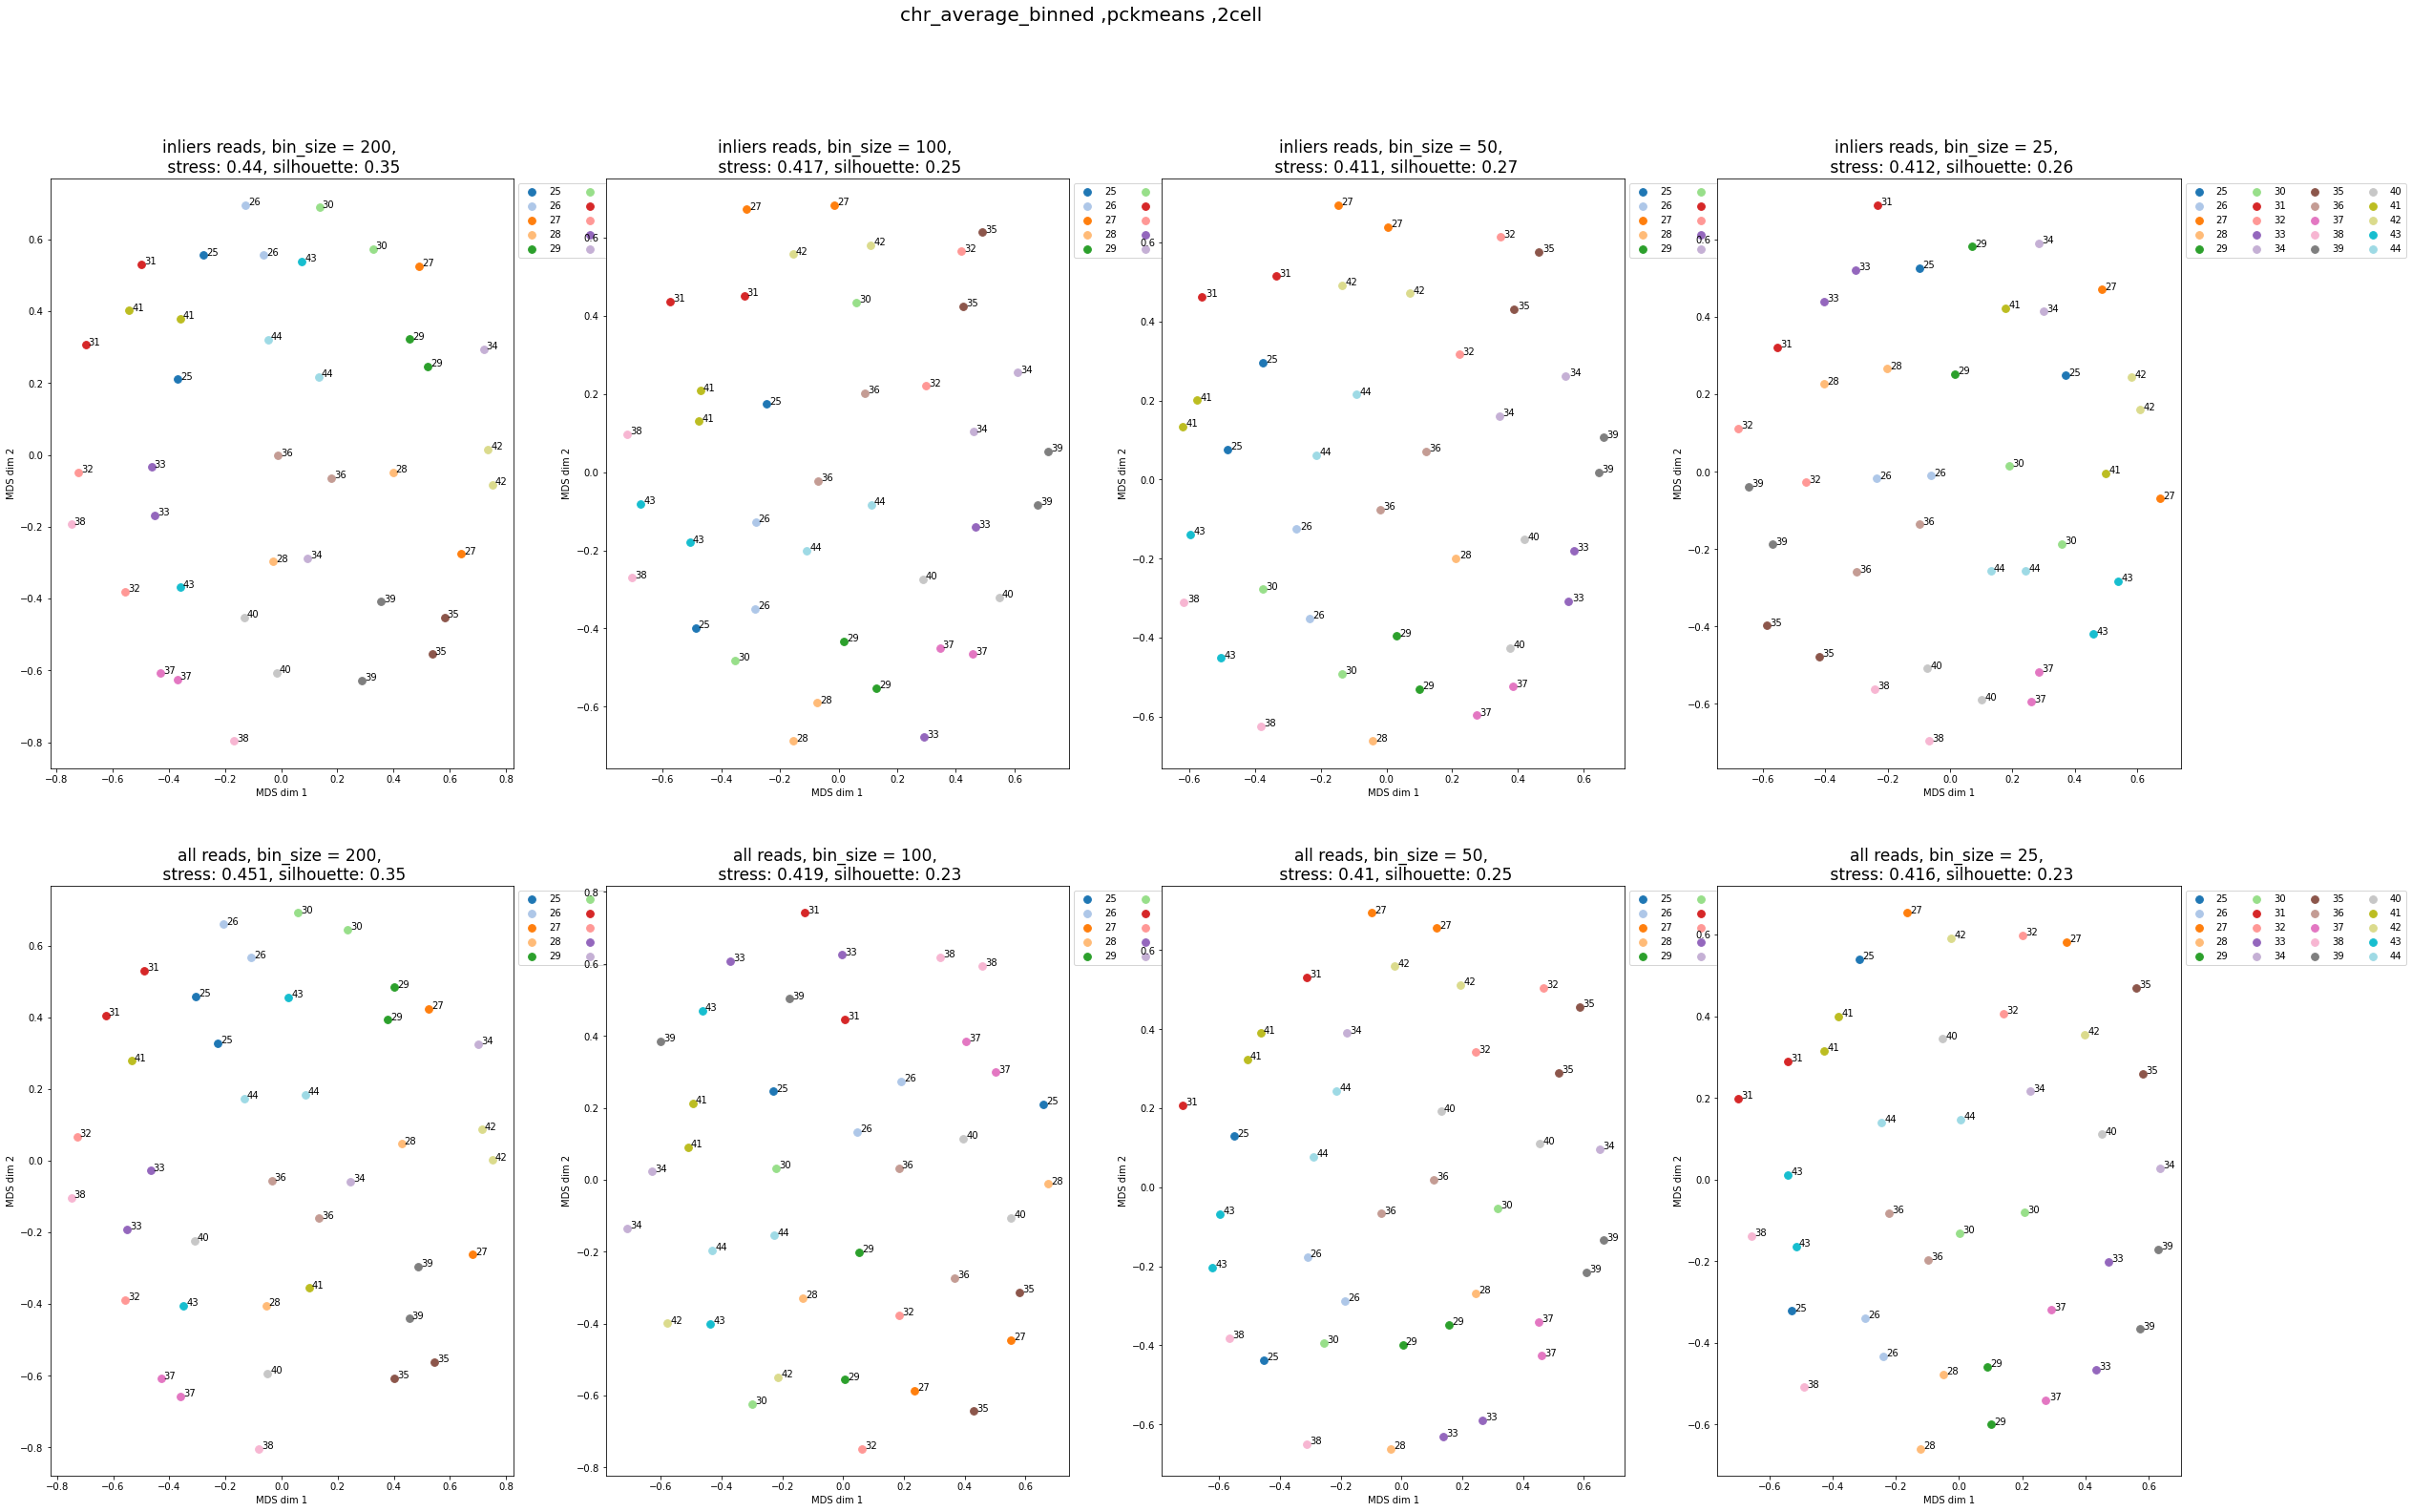

In [42]:
method = "chr_average_binned" #"chr_average_bigger"
clustering_method = "pckmeans"
stage = "2cell"

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 25))
for row, reads_to_include in enumerate(["inliers", "all"]):
    for col, bin_size in enumerate([200, 100, 50, 25]):
    
        
        inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
        inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
        dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
        
        
        data = read_data(clustering_method, reads_to_include)
        _4cell_df = data.loc[data.stage == stage]
        embryos = np.sort(_4cell_df.embryo_id.unique())
        vals = np.arange(0,len(embryos))
        embryo_color_dict = dict(zip(embryos, vals))
        color_list = plt.cm.tab20(vals)

        #subsetting the distance matrix to only include the 4cell embryos
        cell_ids = _4cell_df.cell_index.unique()
        dist_id = [cell_id_to_id[i] for i in cell_ids] #indices used to index into the large 109x019 distance matrix
        _4cell_dist = dist[np.ix_(dist_id,dist_id)]
        cell_id_to_4_cell_dist_id = {} #used to index into the smaller (45x45) 4_cell dist matrix array
        for i, cell_id in enumerate(cell_ids):
            cell_id_to_4_cell_dist_id[cell_id] = i

        
        silhouette = silhouette_score(_4cell_dist, metric = "precomputed", labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
        print("silhouette before MDS: ", silhouette)
        
        mds = MDS(dissimilarity='precomputed', random_state=0, n_components = 2)
        mds_cells = mds.fit_transform(_4cell_dist) #shape: 109 x 2
        
        
#         silhouette = silhouette_score(mds_cells, labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
    
        cmap=plt.get_cmap('tab20')
        for embryo in embryos:
            cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
            indeces = [cell_id_to_4_cell_dist_id[cell_id] for cell_id in cell_indeces]
            color = color_list[embryo_color_dict[embryo]]
            axes[row,col].scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 60, color = color, cmap = cmap, marker = "o",  label= embryo)
            for ind in indeces:
                axes[row,col].text(mds_cells[ind,0]+0.01, mds_cells[ind,1], str(embryo))
        lgd = axes[row,col].legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,1))
        axes[row,col].set_xlabel("MDS dim 1")
        axes[row,col].set_ylabel("MDS dim 2")
        axes[row,col].set_title("{} reads, bin_size = {}, \n stress: {}, silhouette: {}".format(reads_to_include, bin_size, stress(dist, mds_cells), np.round(silhouette,2)), fontsize = 17)
plt.suptitle(method + " ," + clustering_method + " ," + stage, fontsize = 20)
plt.savefig("figures/mds_binned_{}.png".format(stage))

## What if we only look at some embryos

silhouette before MDS:  0.20851558929918204
silhouette before MDS:  0.18291171889641766
silhouette before MDS:  0.1665349376746781
silhouette before MDS:  0.14957418043692816
silhouette before MDS:  0.19890719965745846
silhouette before MDS:  0.1615215177376207
silhouette before MDS:  0.14915572467147364
silhouette before MDS:  0.1344031767722771


Text(0.5, 0.98, 'chr_average_binned ,pckmeans ,4cell')

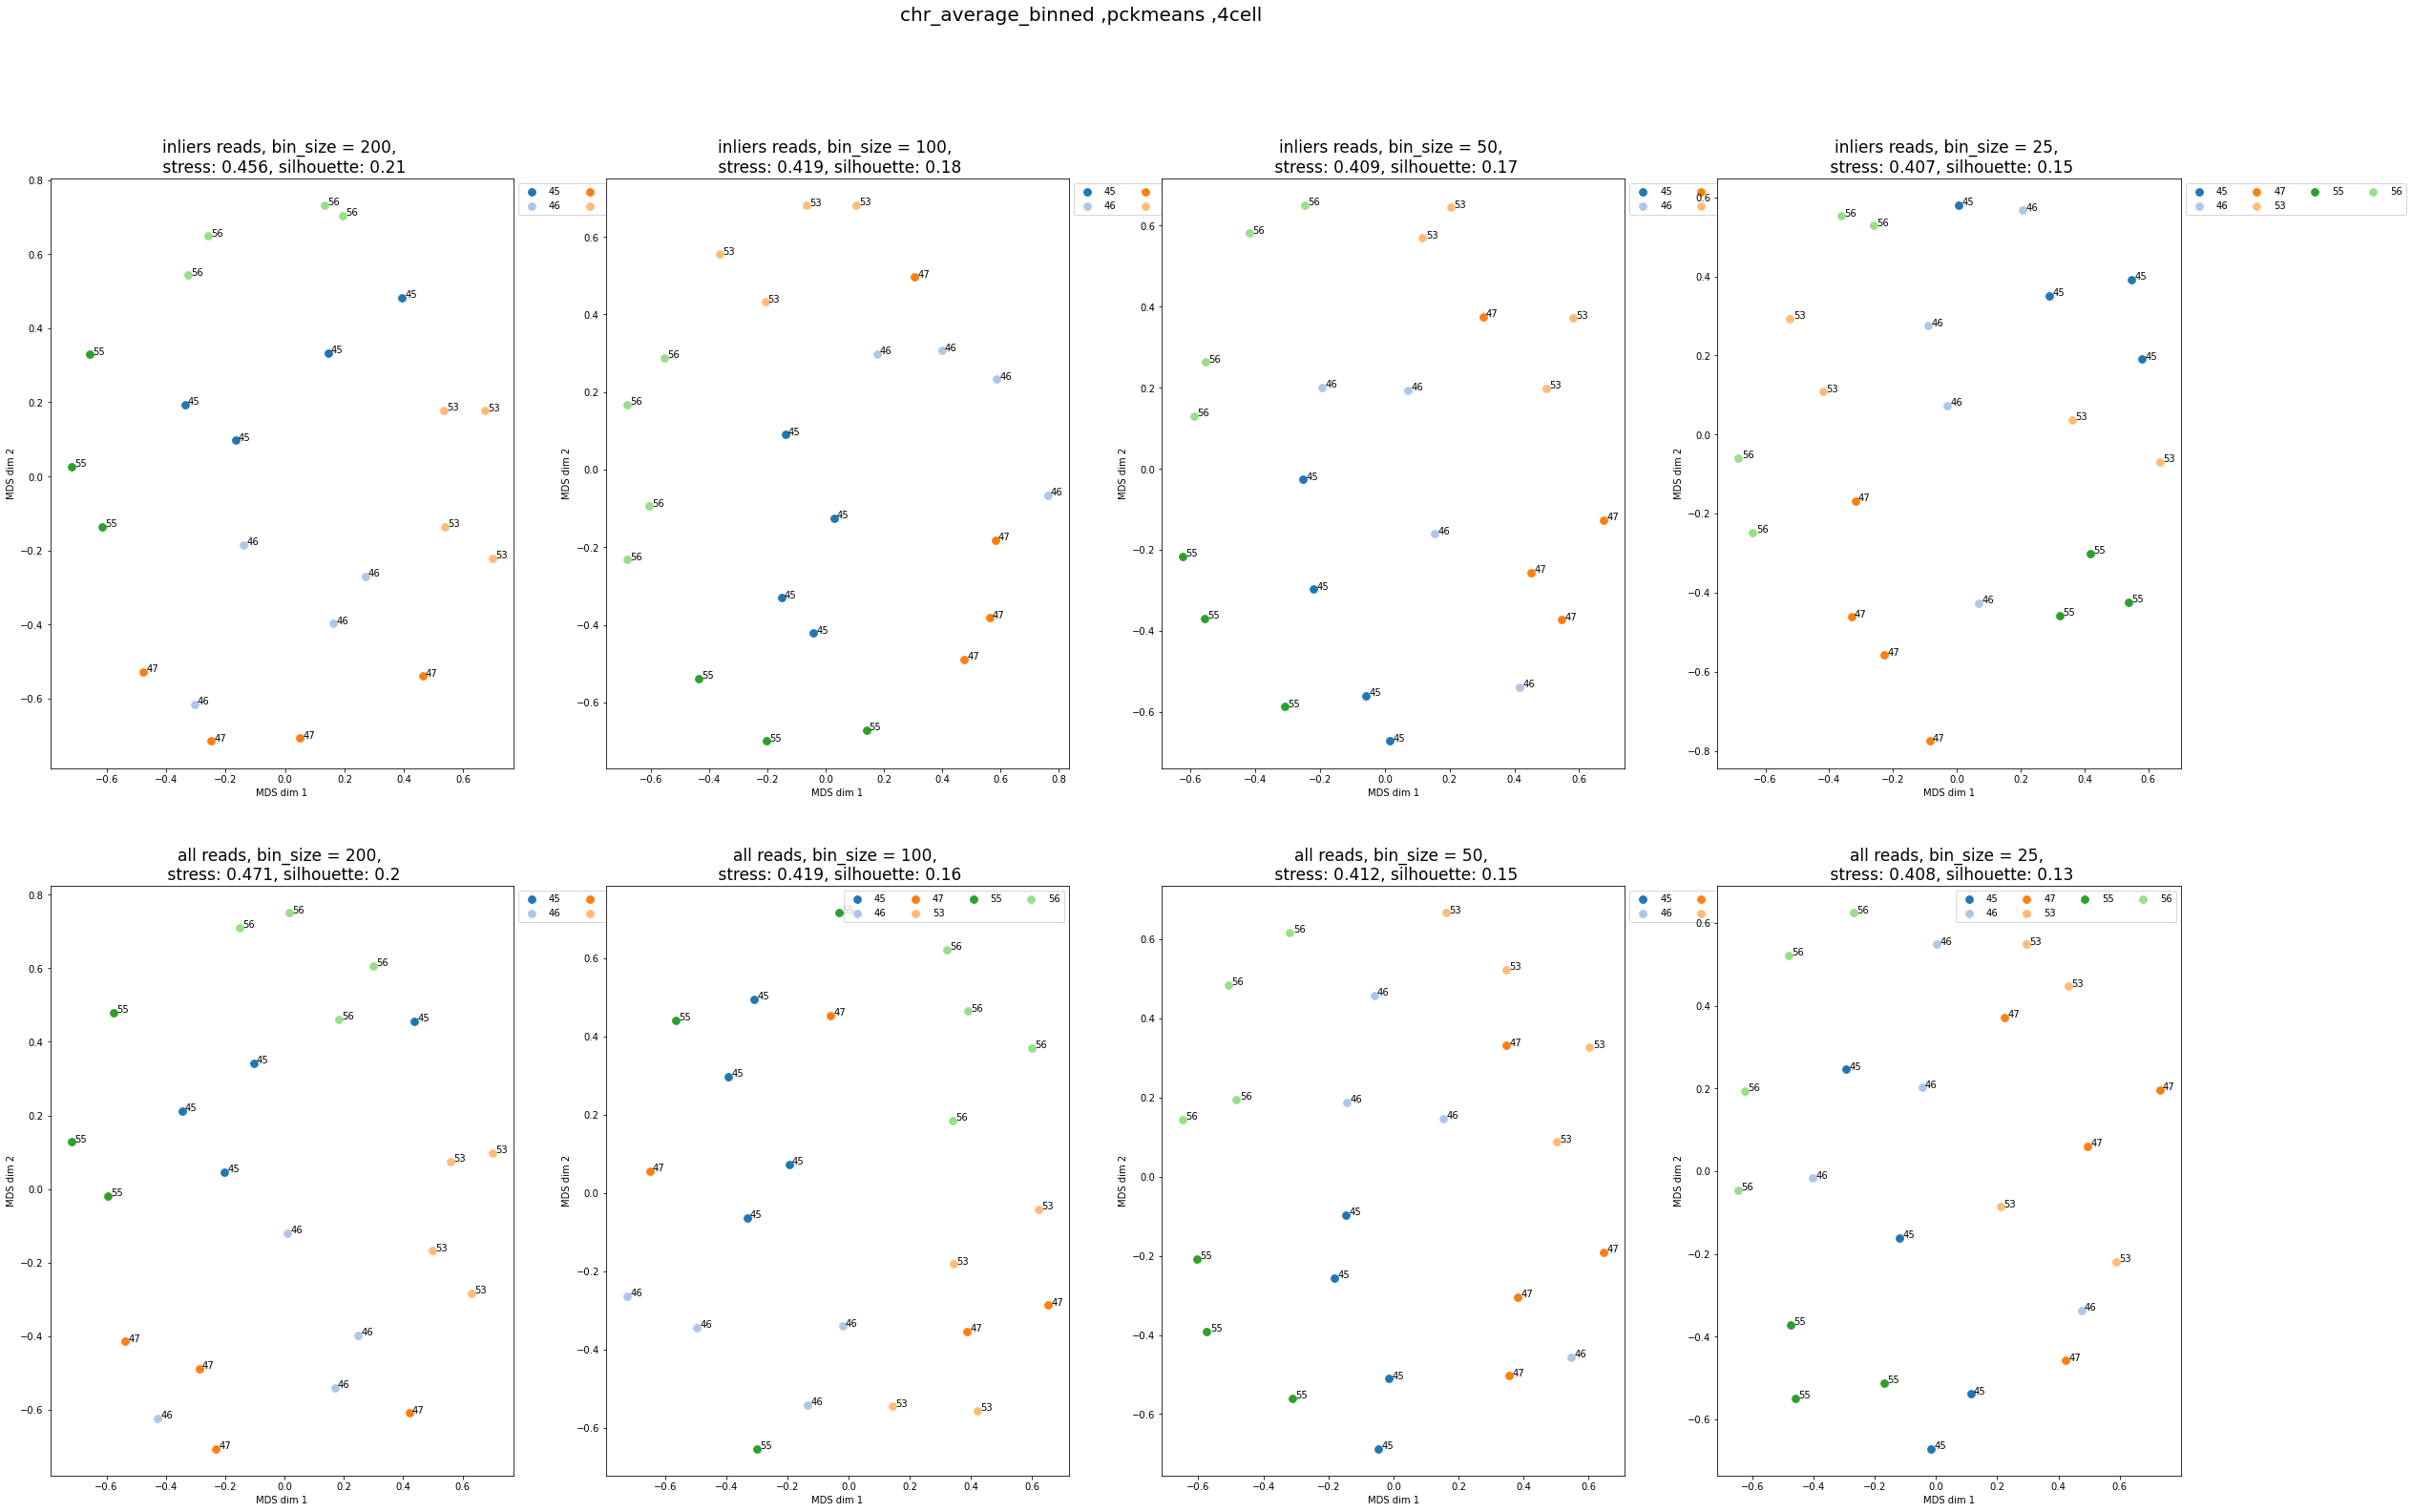

In [43]:
method = "chr_average_binned" #"chr_average_bigger"
clustering_method = "pckmeans"
stage = "4cell"
embryo_indeces = [45,  46, 47,53, 55, 56]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 25))
for row, reads_to_include in enumerate(["inliers", "all"]):
    for col, bin_size in enumerate([200, 100, 50, 25]):
    
        
        inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
        inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
        dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
        
        
        data = read_data(clustering_method, reads_to_include)
        _4cell_df = data.loc[(data.stage == stage) & data.embryo_id.isin(embryo_indeces)]
        embryos = np.sort(_4cell_df.embryo_id.unique())
        vals = np.arange(0,len(embryos))
        embryo_color_dict = dict(zip(embryos, vals))
        color_list = plt.cm.tab20(vals)

        #subsetting the distance matrix to only include the 4cell embryos
        cell_ids = _4cell_df.cell_index.unique()
        dist_id = [cell_id_to_id[i] for i in cell_ids] #indices used to index into the large 109x019 distance matrix
        _4cell_dist = dist[np.ix_(dist_id,dist_id)]
        cell_id_to_4_cell_dist_id = {} #used to index into the smaller (45x45) 4_cell dist matrix array
        for i, cell_id in enumerate(cell_ids):
            cell_id_to_4_cell_dist_id[cell_id] = i

        
        silhouette = silhouette_score(_4cell_dist, metric = "precomputed", labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
        print("silhouette before MDS: ", silhouette)
        
        mds = MDS(dissimilarity='precomputed', random_state=0, n_components = 2)
        mds_cells = mds.fit_transform(_4cell_dist) #shape: 109 x 2
        
        
#         silhouette = silhouette_score(mds_cells, labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
    
        cmap=plt.get_cmap('tab20')
        for embryo in embryos:
            cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
            indeces = [cell_id_to_4_cell_dist_id[cell_id] for cell_id in cell_indeces]
            color = color_list[embryo_color_dict[embryo]]
            axes[row,col].scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 60, color = color, cmap = cmap, marker = "o",  label= embryo)
            for ind in indeces:
                axes[row,col].text(mds_cells[ind,0]+0.01, mds_cells[ind,1], str(embryo))
        lgd = axes[row,col].legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,1))
        axes[row,col].set_xlabel("MDS dim 1")
        axes[row,col].set_ylabel("MDS dim 2")
        axes[row,col].set_title("{} reads, bin_size = {}, \n stress: {}, silhouette: {}".format(reads_to_include, bin_size, stress(dist, mds_cells), np.round(silhouette,2)), fontsize = 17)
plt.suptitle(method + " ," + clustering_method + " ," + stage, fontsize = 20)
# plt.savefig("figures/mds_binned_{}.png".format(stage))

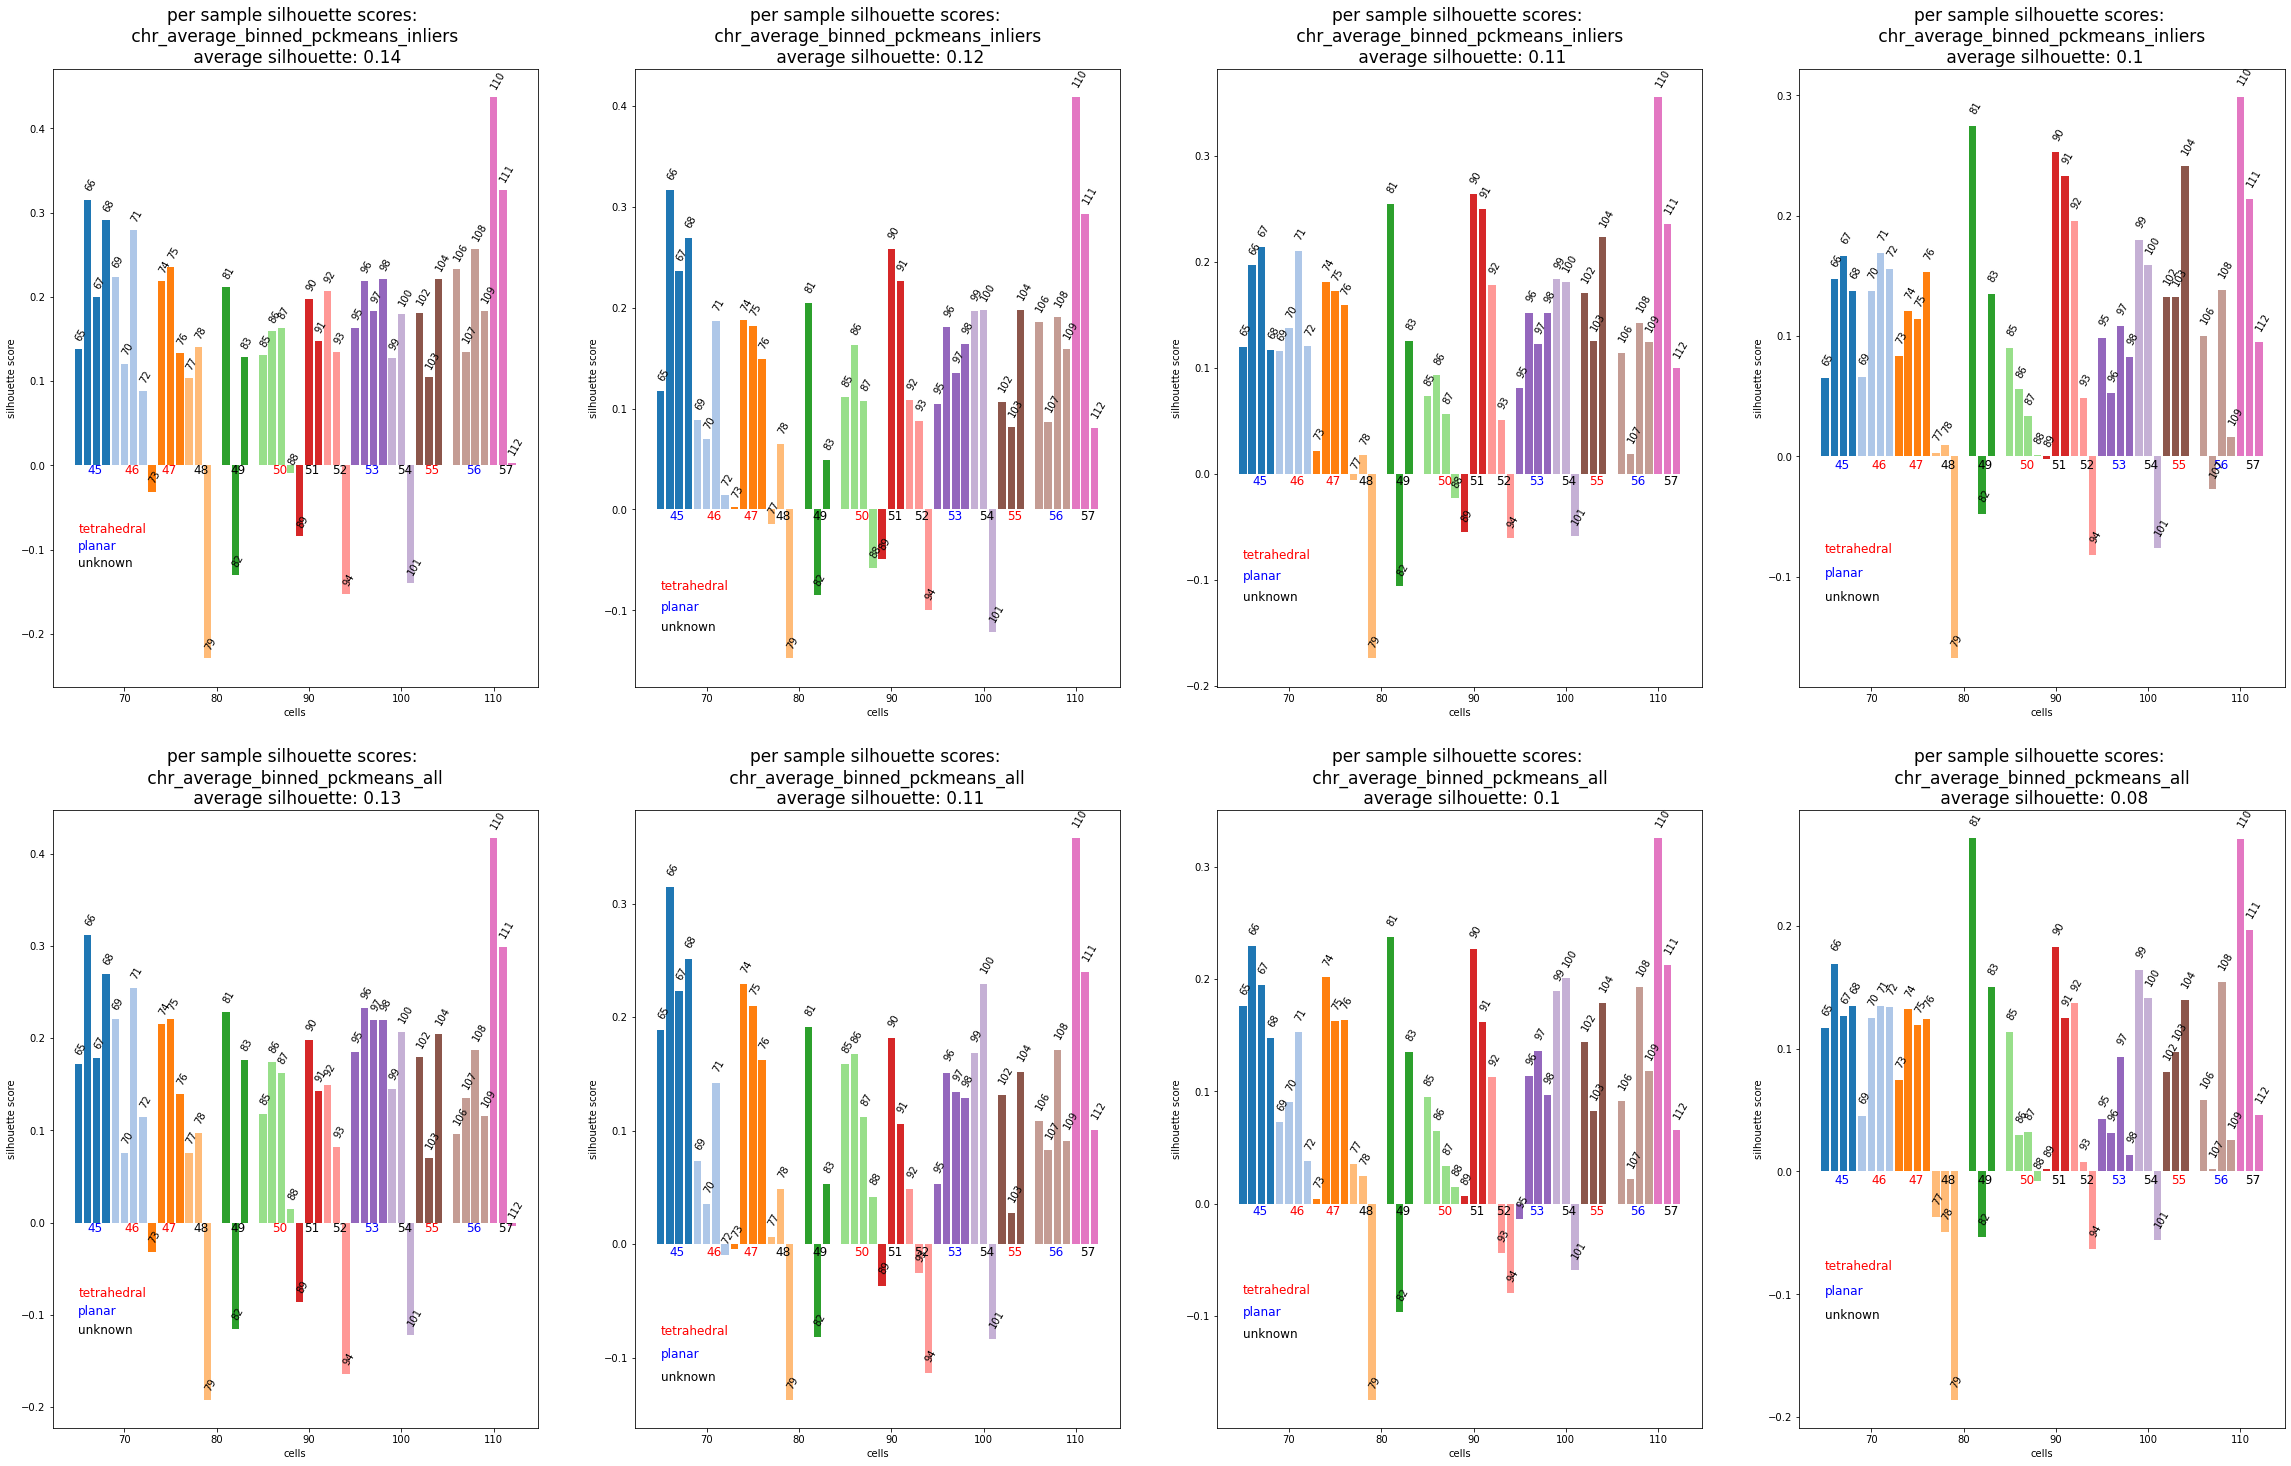

In [42]:
method = "chr_average_binned" #"chr_average_bigger"
clustering_method = "pckmeans"
stage = "4cell"
div_color = {'p': 'blue', 't': 'red', "?": 'black'}

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 25))
for row, reads_to_include in enumerate(["inliers", "all"]):
    for col, bin_size in enumerate([200, 100, 50, 25]):
    
        
        inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
        inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
        dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
        
        
        data = read_data(clustering_method, reads_to_include)
        _4cell_df = data.loc[data.stage == '4cell']
        embryos = np.sort(_4cell_df.embryo_id.unique())
        vals = np.arange(0,len(embryos))
        embryo_color_dict = dict(zip(embryos, vals))
        color_list = plt.cm.tab20(vals)

        #subsetting the distance matrix to only include the 4cell embryos
        cell_ids = _4cell_df.cell_index.unique()
        dist_id = [cell_id_to_id[i] for i in cell_ids] #indices used to index into the large 109x019 distance matrix
        _4cell_dist = dist[np.ix_(dist_id,dist_id)]
        cell_id_to_4_cell_dist_id = {} #used to index into the smaller (45x45) 4_cell dist matrix array
        for i, cell_id in enumerate(cell_ids):
            cell_id_to_4_cell_dist_id[cell_id] = i

        
        silhouettes = silhouette_samples(_4cell_dist, metric = "precomputed", labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
        
        cmap=plt.get_cmap('tab20')
        for embryo in embryos:
            cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
            indeces = [cell_id_to_4_cell_dist_id[cell_id] for cell_id in cell_indeces]
            color = color_list[embryo_color_dict[embryo]]
            axes[row,col].bar(cell_ids[indeces], silhouettes[indeces], color = color) 
            axes[row,col].text(np.mean(cell_ids[indeces])-0.5, -0.01, str(embryo), color = div_color[div[embryo]], fontsize = 'large')
            for ind in indeces:
                axes[row,col].text(cell_ids[ind]-0.5, silhouettes[ind] + 0.01, s = str(cell_ids[ind]), rotation = '60')
        axes[row,col].text(65, -0.1, "planar", color = "blue", fontsize = "large")
        axes[row,col].text(65, -0.08, "tetrahedral", color = "red", fontsize = "large")
        axes[row,col].text(65, -0.12, "unknown", color = "black", fontsize = "large")
        axes[row,col].set_xlabel("cells")
        axes[row,col].set_ylabel("silhouette score")
        axes[row,col].set_title("per sample silhouette scores: \n {}_{}_{} \n average silhouette: {}".format(method, clustering_method, reads_to_include, np.round(np.mean(silhouettes),2)), fontsize = 17)
# fig.savefig('figures/silhouette{}_{}_{}.png'.format(method, clustering_method, reads_to_include))


In [57]:
for i in range(100):
    print(i)
    print(data.loc[(data.cell_index == i)&(data.chr>19)&(data.chr<22)].groupby(['chr', 'pckmeans_cluster']).size() )

0
Series([], dtype: int64)
1
chr  pckmeans_cluster
20   0.0                 128
21   0.0                  14
dtype: int64
2
chr  pckmeans_cluster
20   0.0                 16
     1.0                 25
dtype: int64
3
chr  pckmeans_cluster
20   0.0                 39
     1.0                 70
dtype: int64
4
chr  pckmeans_cluster
20   0.0                 54
     1.0                 78
dtype: int64
5
chr  pckmeans_cluster
20   0.0                 28
     1.0                 18
dtype: int64
6
chr  pckmeans_cluster
20   0.0                 66
21   0.0                  4
dtype: int64
7
chr  pckmeans_cluster
20   0.0                 148
     1.0                 260
dtype: int64
8
chr  pckmeans_cluster
20   0.0                 382
21   0.0                   1
dtype: int64
9
chr  pckmeans_cluster
20   0.0                 59
21   0.0                  6
dtype: int64
10
chr  pckmeans_cluster
20   0.0                 281
21   0.0                   1
dtype: int64
11
chr  pckmeans_cluster
20   0.0 